In [1]:
import logging

import anndata
import numpy as np
import pandas as pd
import plotnine as p
import matplotlib.pyplot as plt
import scvi
from scvi.model.utils import mde
import scHPL
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

Global seed set to 0


In [2]:
alladata = anndata.read('GSE213516.h5ad')

In [3]:
alladata.obs['total_counts'] = np.array(alladata.X.sum(1))

In [4]:
alladata

AnnData object with n_obs × n_vars = 139761 × 33538
    obs: 'sample_name', 'total_counts'
    var: 'gene_id', 'feature_type'

In [5]:
adata = alladata[alladata.obs.sample(20_000).index].copy()

In [6]:
adata

AnnData object with n_obs × n_vars = 20000 × 33538
    obs: 'sample_name', 'total_counts'
    var: 'gene_id', 'feature_type'

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key = 'sample_name',
    size_factor_key = 'total_counts'
)

model = scvi.model.SCVI(
    adata,
    gene_likelihood = 'nb'
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
model.train(60, check_val_every_n_epoch = 1, enable_progress_bar = True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 60/60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:12<00:00,  3.18s/it, loss=4.73e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [03:12<00:00,  3.21s/it, loss=4.73e+03, v_num=1]


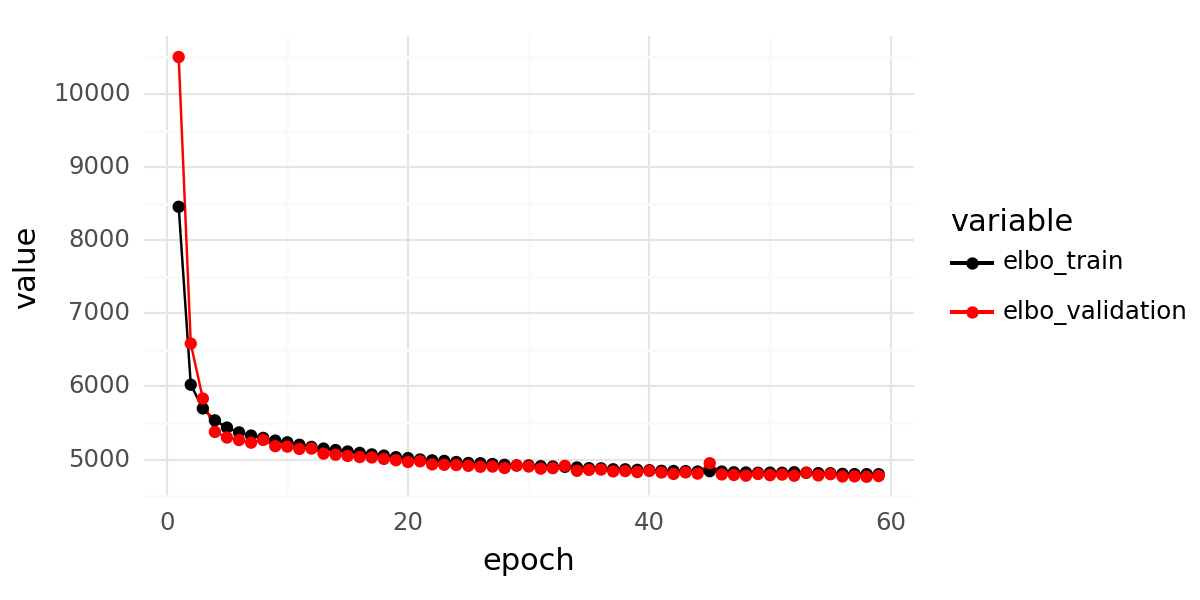

In [10]:
history_df = (
    model.history['elbo_train'].astype(float)
    .join(model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [591]:
cell_iloc = np.random.choice(np.arange(adata.shape[0]), (5), replace = False)

In [592]:
genes = np.random.choice(sadata.X.sum(0).nonzero()[1], (10), replace = False)

In [593]:
scvi.settings.verbosity = logging.WARNING
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [625]:
for run in range(2, 6 + 1):
    
    scvi.model.SCVI.setup_anndata(
        adata,
        batch_key = 'sample_name',
        size_factor_key = 'total_counts'
    )

    model = scvi.model.SCVI(
        adata,
        gene_likelihood = 'nb'
    )
    
    cell_iloc = np.random.choice(np.arange(adata.shape[0]), (5), replace = False)
    genes = np.random.choice(sadata.X.sum(0).nonzero()[1], (10), replace = False)

    cell_gene_samples_histograms = []

    for epoch in tqdm(range(1, 60 + 1)):
        model.train(1, check_val_every_n_epoch = 1, enable_progress_bar = False)

        sadata = adata[cell_iloc].copy()

        scdl_ = model._make_data_loader(sadata)

        for tensors in scdl_:
            pass

        inference = model.module.inference(**model.module._get_inference_input(tensors))
        qz = inference['qz']
        inference['z'] = qz.sample_n(128)

        generative = model.module.generative(**model.module._get_generative_input(tensors, inference))
        px = generative['px']
        px_sample = px.sample()

        gene_samples_histograms = []
        for g_ in genes:
            gene_samples = px_sample[:, :, g_].cpu()
            gene_samples_df = pd.DataFrame(gene_samples, columns = cell_iloc).reset_index()
            gene_samples_df_long = (
                gene_samples_df
                .melt(id_vars = ['index'], var_name = 'cell', value_name = 'count')
            )
            gene_samples_histogram = (
                gene_samples_df_long
                .groupby(['cell', 'count'], observed = True)
                .size()
                .rename('observations')
                .reset_index()
            )
            gene_samples_histogram['gene'] = g_
            gene_samples_histograms += [gene_samples_histogram]

        cell_gene_samples_histogram = pd.concat(gene_samples_histograms)

        cell_gene_samples_histogram['epoch'] = epoch

        cell_gene_samples_histograms += [cell_gene_samples_histogram]

    cell_gene_samples_histograms = pd.concat(cell_gene_samples_histograms)
    
    history_df = (
        model.history['elbo_train'].astype(float)
        .join(model.history['elbo_validation'].astype(float))
        .reset_index()
        .melt(id_vars = ['epoch'])
    )
    
    cell_gene_observations = (
        pd.DataFrame(tensors['X'][:, genes], columns = genes, index = cell_iloc)
        .reset_index()
        .rename(columns = {'index': 'cell'})
        .melt(id_vars = 'cell', var_name = 'gene', value_name = 'count')
    )
    
    p.options.figure_size = (9, 10)

    for epoch, grp_ in tqdm(cell_gene_samples_histograms.groupby(['epoch'])):
        elbo_train = history_df.query('variable == "elbo_train"').query('epoch == (@epoch[0] - 1)')['value'].values[0]

        p_ = (
            p.ggplot(p.aes(x = 'count', y = 'observations'), grp_)
            + p.scale_x_log10()
            + p.coord_cartesian(xlim = (np.log10(0.8), np.log10(300)), ylim = (0, 100))
            + p.geom_vline(p.aes(xintercept = 'count'), color = 'red', data = cell_gene_observations)
            + p.geom_segment(p.aes(xend = 'count'), yend = 0, size = 1.0)
            + p.theme_minimal()
            + p.facet_grid('gene ~ cell', labeller = 'label_both')
            + p.labs(title = f'Epoch {epoch[0]} - elbo_trian {elbo_train:.2f}')
        )

        p_.save(f'random{run}/{epoch}.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [06:27<00:00,  6.47s/it]


In [626]:
scvi.data.poisson_gene_selection(adata)

Sampling from binomial...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13389.17it/s]


In [643]:
for run in range(1, 6 + 1):
    
    scvi.model.SCVI.setup_anndata(
        adata,
        batch_key = 'sample_name',
        size_factor_key = 'total_counts'
    )

    model = scvi.model.SCVI(
        adata,
        gene_likelihood = 'nb'
    )
    
    cell_iloc = np.random.choice(np.arange(adata.shape[0]), (5), replace = False)
    idx_ = sadata.X.sum(0).nonzero()[1]
    genes = (
        adata.var
        .iloc[idx_]
        .assign(idx = idx_)
        .sort_values('prob_zero_enrichment_rank', ascending = False)
        .head(10)['idx']
        .values
    )

    cell_gene_samples_histograms = []

    for epoch in tqdm(range(1, 60 + 1)):
        model.train(1, check_val_every_n_epoch = 1, enable_progress_bar = False)

        sadata = adata[cell_iloc].copy()

        scdl_ = model._make_data_loader(sadata)

        for tensors in scdl_:
            pass

        inference = model.module.inference(**model.module._get_inference_input(tensors))
        qz = inference['qz']
        inference['z'] = qz.sample_n(128)

        generative = model.module.generative(**model.module._get_generative_input(tensors, inference))
        px = generative['px']
        px_sample = px.sample()

        gene_samples_histograms = []
        for g_ in genes:
            gene_samples = px_sample[:, :, g_].cpu()
            gene_samples_df = pd.DataFrame(gene_samples, columns = cell_iloc).reset_index()
            gene_samples_df_long = (
                gene_samples_df
                .melt(id_vars = ['index'], var_name = 'cell', value_name = 'count')
            )
            gene_samples_histogram = (
                gene_samples_df_long
                .groupby(['cell', 'count'], observed = True)
                .size()
                .rename('observations')
                .reset_index()
            )
            gene_samples_histogram['gene'] = g_
            gene_samples_histograms += [gene_samples_histogram]

        cell_gene_samples_histogram = pd.concat(gene_samples_histograms)

        cell_gene_samples_histogram['epoch'] = epoch

        cell_gene_samples_histograms += [cell_gene_samples_histogram]

    cell_gene_samples_histograms = pd.concat(cell_gene_samples_histograms)
    
    history_df = (
        model.history['elbo_train'].astype(float)
        .join(model.history['elbo_validation'].astype(float))
        .reset_index()
        .melt(id_vars = ['epoch'])
    )
    
    cell_gene_observations = (
        pd.DataFrame(tensors['X'][:, genes], columns = genes, index = cell_iloc)
        .reset_index()
        .rename(columns = {'index': 'cell'})
        .melt(id_vars = 'cell', var_name = 'gene', value_name = 'count')
    )
    
    p.options.figure_size = (9, 10)

    for epoch, grp_ in tqdm(cell_gene_samples_histograms.groupby(['epoch'])):
        elbo_train = history_df.query('variable == "elbo_train"').query('epoch == (@epoch[0] - 1)')['value'].values[0]

        p_ = (
            p.ggplot(p.aes(x = 'count', y = 'observations'), grp_)
            + p.scale_x_log10()
            + p.coord_cartesian(xlim = (np.log10(0.8), np.log10(300)), ylim = (0, 100))
            + p.geom_vline(p.aes(xintercept = 'count'), color = 'red', data = cell_gene_observations)
            + p.geom_segment(p.aes(xend = 'count'), yend = 0, size = 1.0)
            + p.theme_minimal()
            + p.facet_grid('gene ~ cell', labeller = 'label_both')
            + p.labs(title = f'Epoch {epoch[0]} - elbo_trian {elbo_train:.2f}')
        )

        p_.save(f'hvg{run}/{epoch}.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [06:37<00:00,  6.62s/it]


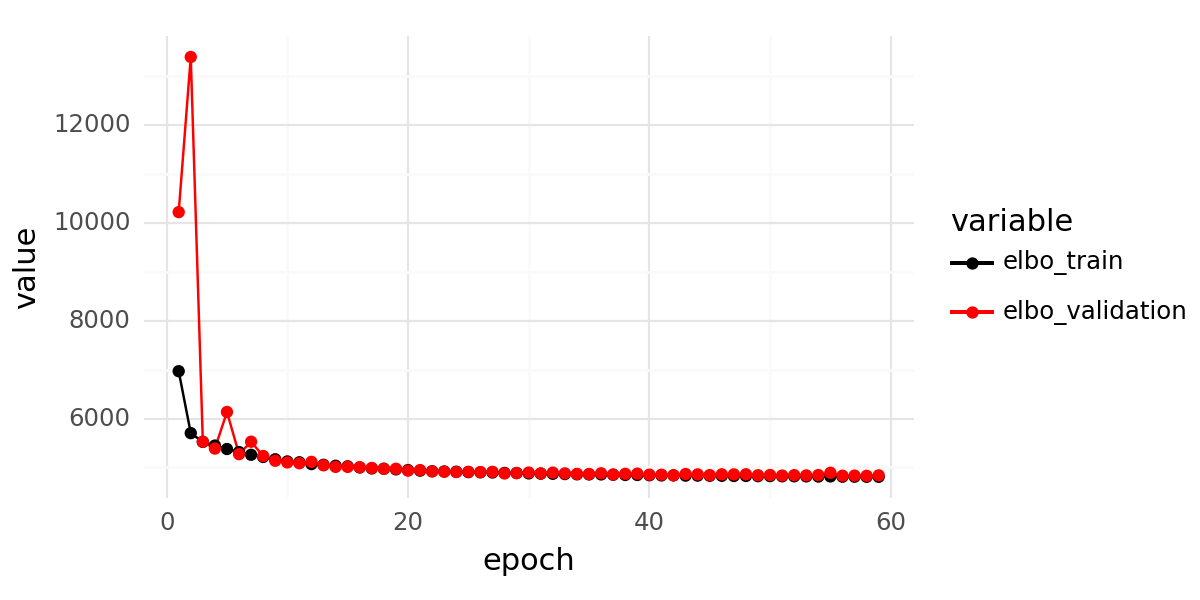

In [648]:
history_df = (
    model.history['elbo_train'].astype(float)
    .join(model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

In [596]:
cell_gene_observations = (
    pd.DataFrame(tensors['X'][:, genes], columns = genes, index = cell_iloc)
    .reset_index()
    .rename(columns = {'index': 'cell'})
    .melt(id_vars = 'cell', var_name = 'gene', value_name = 'count')
)

In [619]:
p.options.figure_size = (9, 10)

for epoch, grp_ in tqdm(cell_gene_samples_histograms.groupby(['epoch'])):
    elbo_train = history_df.query('variable == "elbo_train"').query('epoch == (@epoch[0] - 1)')['value'].values[0]
    
    p_ = (
        p.ggplot(p.aes(x = 'count', y = 'observations'), grp_)
        + p.scale_x_log10()
        + p.coord_cartesian(xlim = (np.log10(0.8), np.log10(300)), ylim = (0, 100))
        + p.geom_vline(p.aes(xintercept = 'count'), color = 'red', data = cell_gene_observations)
        + p.geom_segment(p.aes(xend = 'count'), yend = 0, size = 1.0)
        + p.theme_minimal()
        + p.facet_grid('gene ~ cell', labeller = 'label_both')
        + p.labs(title = f'Epoch {epoch[0]} - elbo_trian {elbo_train:.2f}')
    )

    p_.save(f'random1/{epoch}.png')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [07:50<00:00,  7.85s/it]


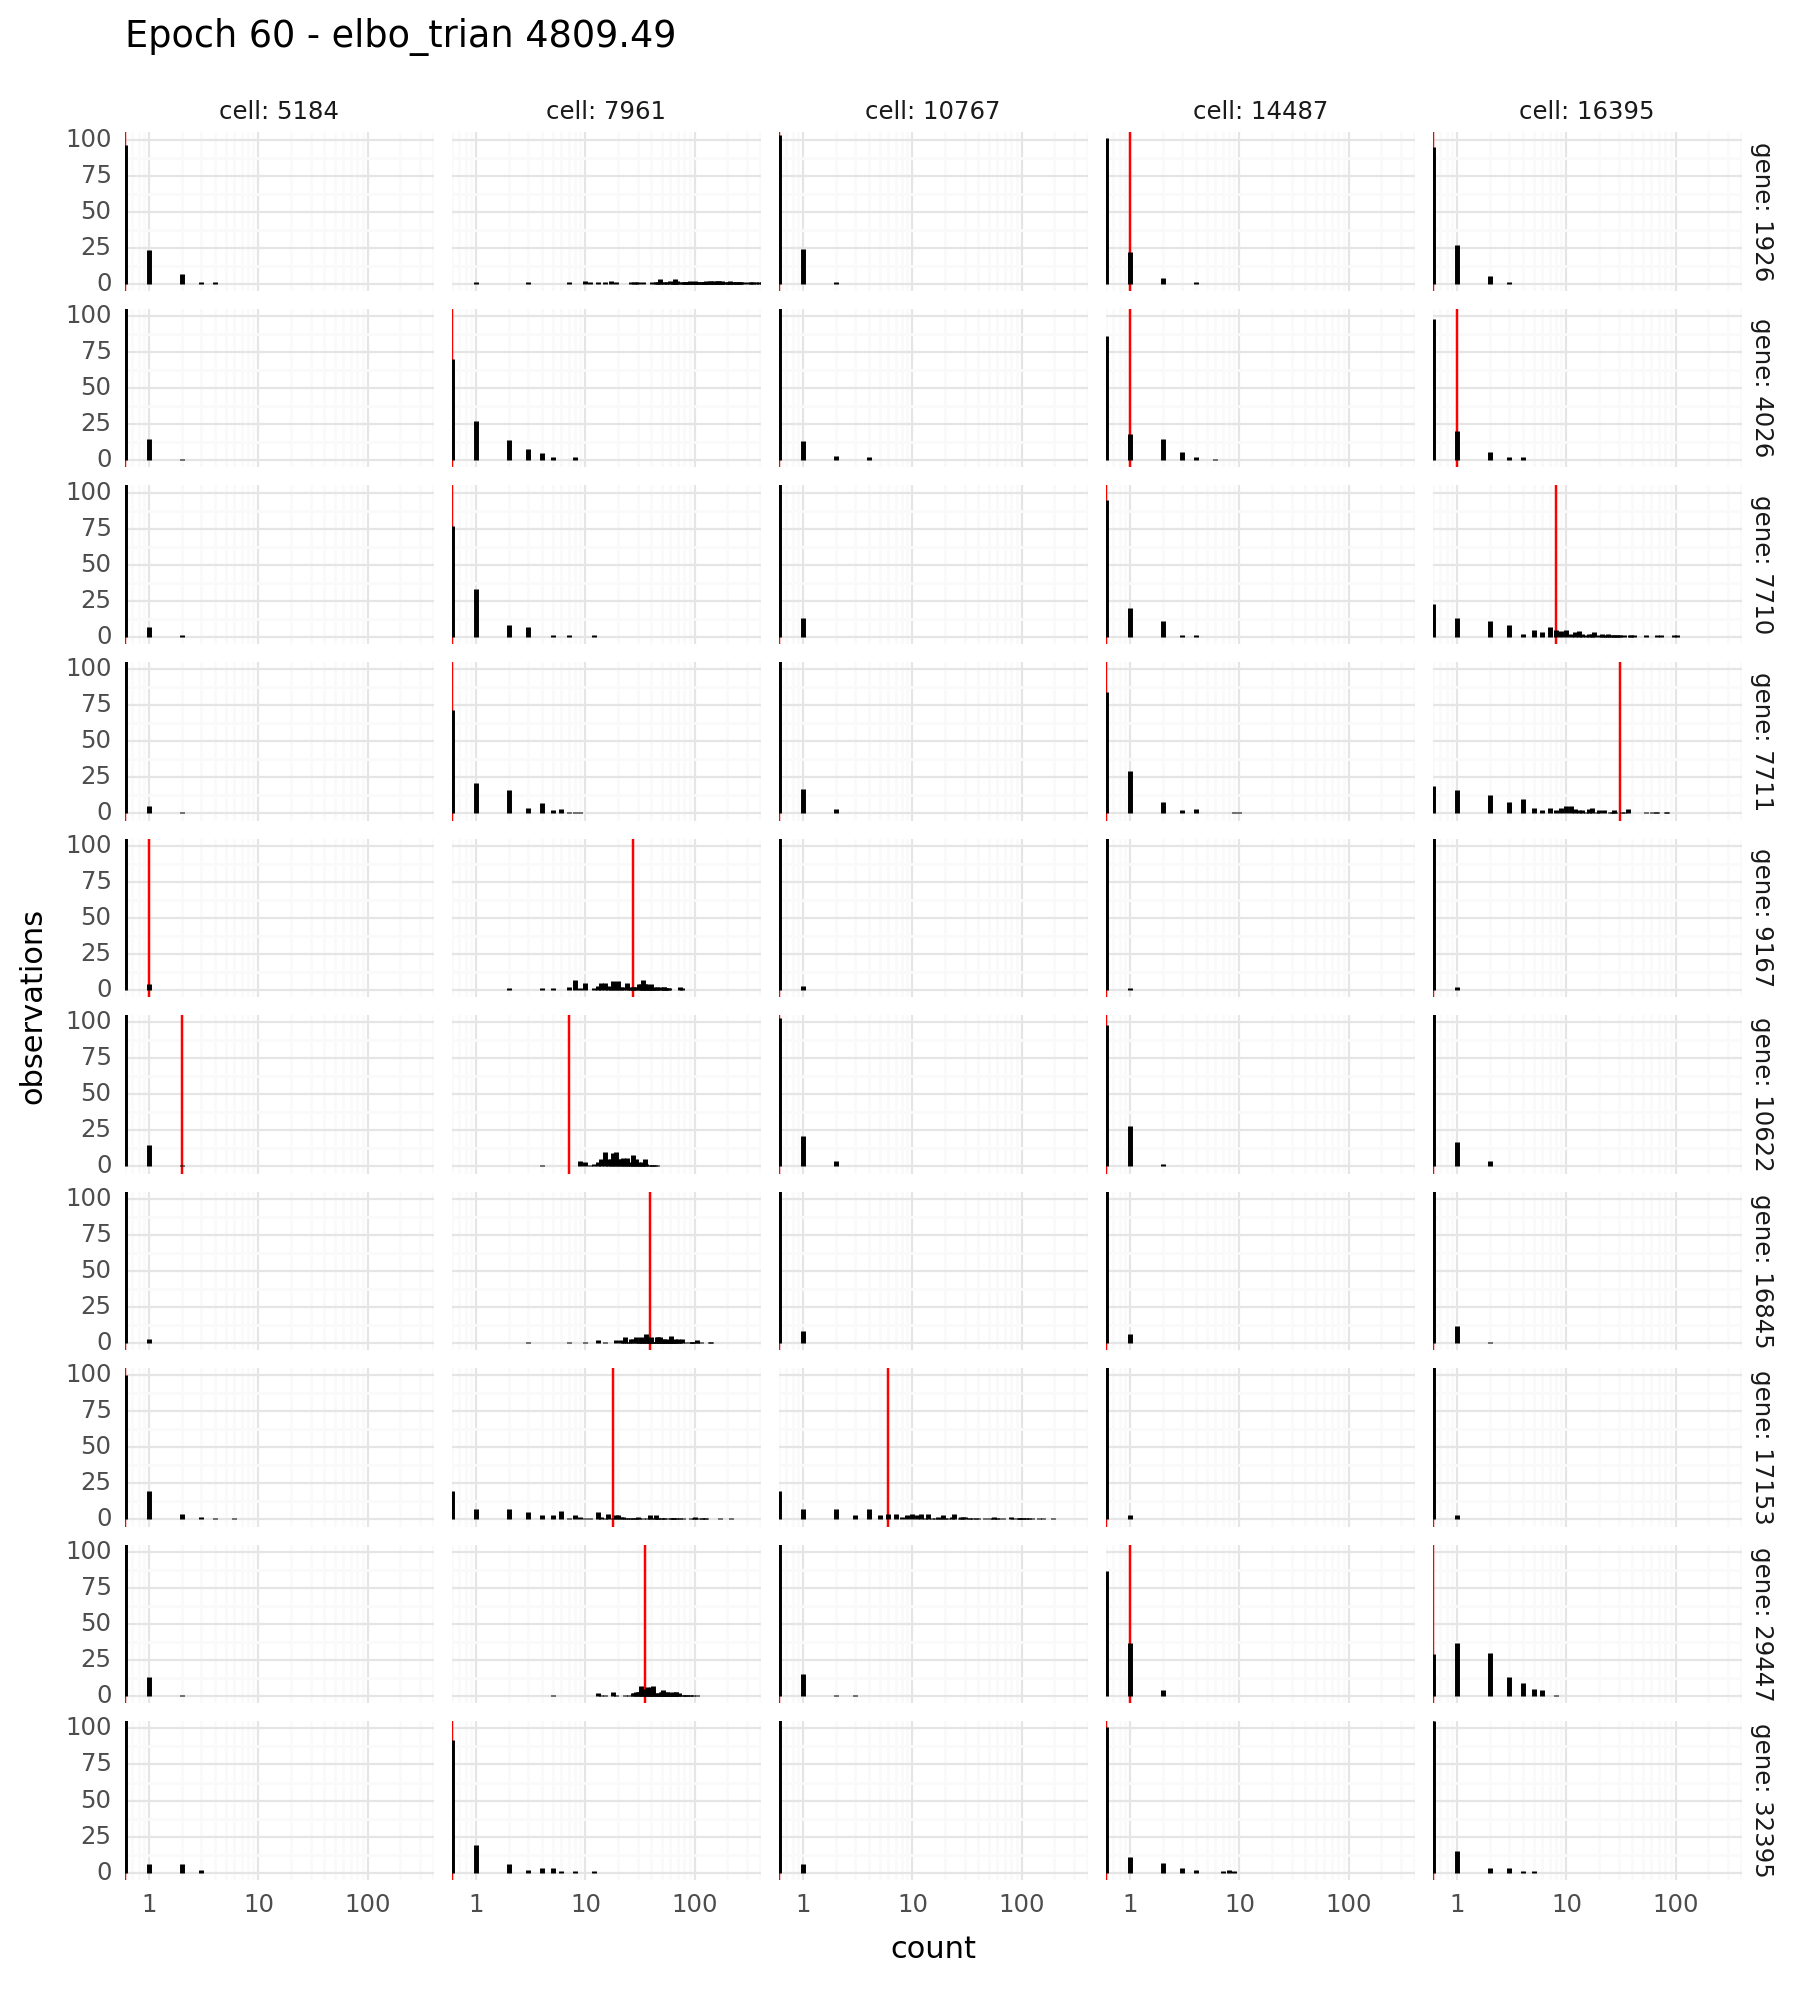

<Figure Size: (900 x 1000)>

In [649]:
p.options.figure_size = (9, 10)

elbo_train = history_df.query('variable == "elbo_train"').query('epoch == (@epoch[0] - 1)')['value'].values[0]

(
    p.ggplot(p.aes(x = 'count', y = 'observations'), grp_)
    + p.scale_x_log10()
    + p.coord_cartesian(xlim = (np.log10(0.8), np.log10(300)), ylim = (0, 100))
    + p.geom_vline(p.aes(xintercept = 'count'), color = 'red', data = cell_gene_observations)
    + p.geom_segment(p.aes(xend = 'count'), yend = 0, size = 1.0)
    + p.theme_minimal()
    + p.facet_grid('gene ~ cell', labeller = 'label_both')
    + p.labs(title = f'Epoch {epoch[0]} - elbo_trian {elbo_train:.2f}')
)

In [644]:
adata.obsm['X_scvi'] = model.get_latent_representation(adata)

In [645]:
adata.obsm['X_mde'] = scvi.model.utils.mde(adata.obsm['X_scvi'])

In [646]:
for i, y in enumerate(adata.obsm['X_mde'].T):
    adata.obs[f'mde_{i + 1}'] = y

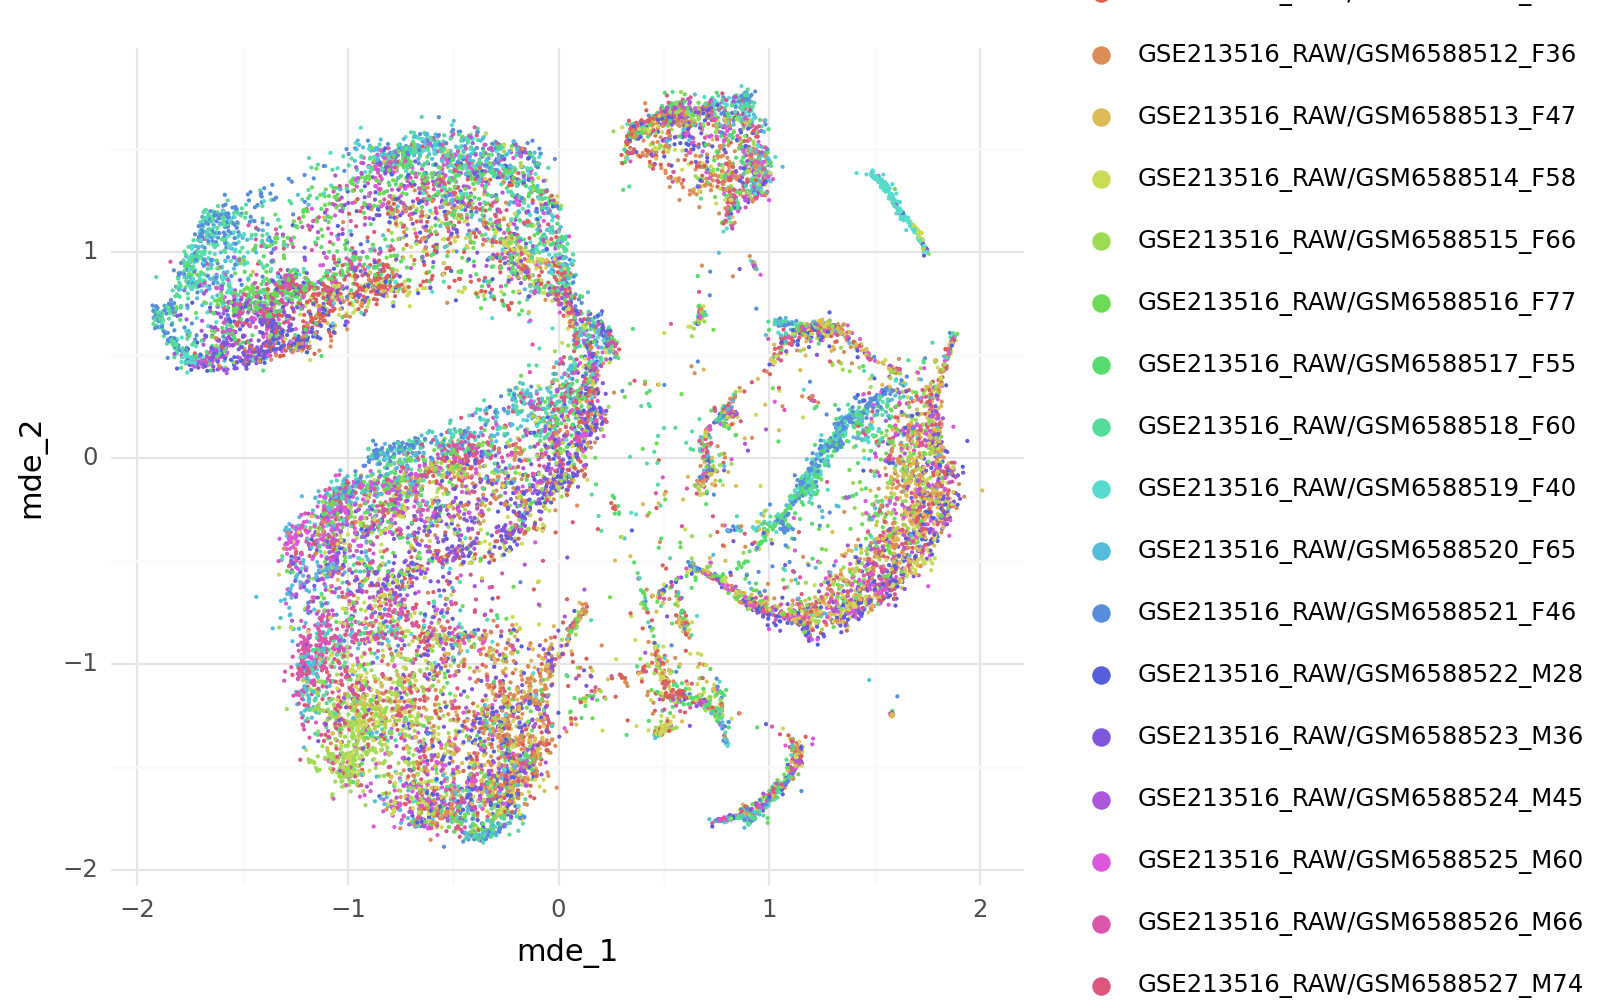

In [647]:
p.options.figure_size = 8, 5

tmp_ = adata.obs

p_ = (
    p.ggplot(p.aes(x = 'mde_1', y = 'mde_2', color = 'sample_name'), tmp_)
    + p.geom_point(shape = '.', size = 0.2)
    + p.theme_minimal()
    + p.guides(color = p.guide_legend(override_aes = {'size': 6}))
)

print(p_)